# Homework 3: Visualizing Data with Movies

Name: Jonathan Manzano

Date: 2024-09-12

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [98]:
# import modules here
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import moviepy.video.io.ImageSequenceClip
import xarray as xr

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [99]:
# define the path to the data folder
data_folder = Path("/home/jon/sjsu/cs185c_fall2024/data")

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [100]:
# make a path to an ocean bottom pressure file
theta_data_path = data_folder / "ECCO" / "Version4" / "Release4" / "interp_monthly" / "THETA" / "THETA_1992_01.nc"

# read in the data
theta_ds = xr.open_dataset(theta_data_path)
longitude = theta_ds["longitude"].values
latitude = theta_ds["latitude"].values
theta_jan1992 = theta_ds["THETA"]
theta_ds.close()

print(theta_jan1992.dims)
print(theta_jan1992.coords)

('time', 'k', 'j', 'i')
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
  * k          (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * time       (time) datetime64[ns] 8B 1992-01-16T12:00:00
    latitude   (j) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    longitude  (i) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    Z          (k) float32 200B ...
    timestep   (time) int64 8B ...


In [101]:
# Subset OBP to first time step
theta_jan1992 = theta_jan1992[0, 0, :, :]

print(theta_jan1992.dims)
print(theta_jan1992.coords)

('j', 'i')
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
    k          int64 8B 0
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    time       datetime64[ns] 8B 1992-01-16T12:00:00
    latitude   (j) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    longitude  (i) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    Z          float32 4B ...
    timestep   int64 8B ...


Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [102]:
# define the longitude/latitude bounds
min_lon = -213
max_lon = -124
min_lat = -20
max_lat = 50

# compute the min/max row/col in the data grid
min_col = np.searchsorted(longitude, min_lon, side="left")
max_col = np.searchsorted(longitude, max_lon, side="right") - 1
min_row = np.searchsorted(latitude, min_lat, side="left")
max_row = np.searchsorted(latitude, max_lat, side="right") - 1

# sanity check
print("The minimum longitude at index", min_col, "is", longitude[min_col])
print("The maximum longitude at index", max_col, "is", longitude[max_col])
print("The minimum latitude at index", min_row, "is", latitude[min_row])
print("The maximum latitude at index", max_row, "is", latitude[max_row])

The minimum longitude at index 0 is -179.75
The maximum longitude at index 111 is -124.25
The minimum latitude at index 140 is -19.75
The maximum latitude at index 279 is 49.75


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [103]:
# subset the data
subset_lon = longitude[min_col : max_col + 1]
subset_lat = latitude[min_row : max_row + 1]
subset_obp_jan2017 = theta_jan1992[min_row: max_row + 1, min_col: max_col + 1]

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

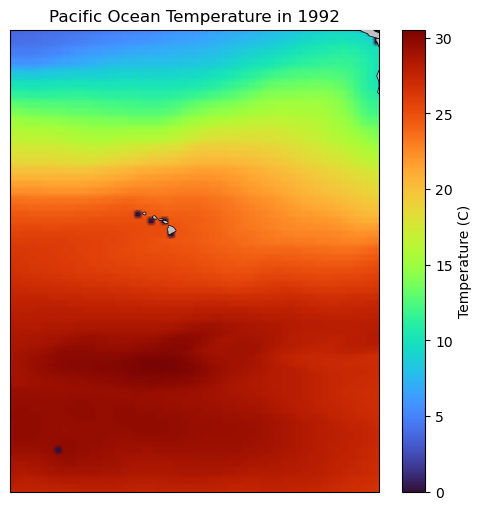

In [104]:
# make a figure object with projection
fig = plt.figure(figsize=(6, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

# plot the sea ice field
plt.pcolormesh(
    subset_lon, subset_lat, subset_obp_jan2017, cmap="turbo", transform=ccrs.PlateCarree(), shading='gouraud'
)
plt.colorbar(orientation="vertical", label="Temperature (C)")

# add coastlines
ax.add_feature(cfeature.LAND, zorder=99, facecolor="silver")
ax.coastlines()

# format the axes
plt.title("Pacific Ocean Temperature in 1992")
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [107]:
frames_directory = Path("/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames")

def plot_panel(year, month):
    # make a path to an ocean bottom pressure file
    theta_data_path = data_folder / "ECCO" / "Version4" / "Release4" / "interp_monthly" / "THETA" / f"THETA_{year}_{month:02}.nc"
    
    # read in the data
    theta_ds = xr.open_dataset(theta_data_path)
    longitude = theta_ds["longitude"].values
    latitude = theta_ds["latitude"].values
    theta = theta_ds["THETA"]
    theta_ds.close()

    # Subset OBP to first time step
    theta = theta[0, 0, :, :]
    
    # define the longitude/latitude bounds
    min_lon = -213
    max_lon = -124
    min_lat = 1
    max_lat = 50

    # compute the min/max row/col in the data grid
    min_col = np.searchsorted(longitude, min_lon, side="left")
    max_col = np.searchsorted(longitude, max_lon, side="right") - 1
    min_row = np.searchsorted(latitude, min_lat, side="left")
    max_row = np.searchsorted(latitude, max_lat, side="right") - 1
    
    # subset the data
    subset_lon = longitude[min_col : max_col + 1]
    subset_lat = latitude[min_row : max_row + 1]
    subset_theta = theta[min_row: max_row + 1, min_col: max_col + 1]
    
    # make a figure object with projection
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # plot the sea ice field
    plt.pcolormesh(
        subset_lon, subset_lat, subset_theta, cmap="turbo", transform=ccrs.PlateCarree(), shading='gouraud'
    )
    plt.colorbar(orientation="vertical", label="Temperature (C)")
    
    # add coastlines
    ax.add_feature(cfeature.LAND, zorder=99, facecolor="silver")
    ax.coastlines()
    
    # format the axes
    plt.title(f"Pacific Ocean Temperature in {year}")
    
    image_file = frames_directory / f"THETA_{year}_{month:02}.png"
    
    plt.savefig(image_file)
    plt.close(fig)

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [108]:
# loop through the data and make a plot for each day
for year in range(1992, 2018):
    for month in range(1, 13):
        plot_panel(year, month)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [109]:
# make a list of files for each movie panel
png_files = [str(file.absolute()) for file in frames_directory.iterdir() if file.is_file()]
print(png_files)

['/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1996_10.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2012_11.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2007_05.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2006_01.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2014_10.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1994_12.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1997_11.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2003_10.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2011_02.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2003_04.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2010_12.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_2005_03.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3

In [110]:
# sort the panels
sorted_png_files = sorted(png_files)
print(sorted_png_files)

['/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_01.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_02.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_03.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_04.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_05.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_06.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_07.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_08.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_09.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_10.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_11.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3/frames/THETA_1992_12.png', '/home/jon/sjsu/cs185c_fall2024/homework/homework_3

In [111]:
# set the frames per second
fps=5

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(sorted_png_files, fps=fps)

# write the video to a file
clip.write_videofile('pacific_ocean_temperature.mp4')

Moviepy - Building video pacific_ocean_temperature.mp4.
Moviepy - Writing video pacific_ocean_temperature.mp4



Moviepy - Done !
Moviepy - video ready pacific_ocean_temperature.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer:

The movie created subsets the world map to the Pacific ocean. THETA data is used to plot the temperature of the ocean. When observing the movie, the thermohaline circulation is noticeable by seeing the warm waters near the equator spreading to the North Pacific Ocean.

What was discovered during researching about Pacific Ocean temperatures over time are El Niño and La Niña events. The eastern equatorial Pacific saw warm anomalies during El Niño years (e.g., 1997-1998 & 2015-2016). Warm seas surface along the coast and across the equator as a consequence of decreased upwelling caused by the trade winds' weakening near Peru. A "pulse" of warm water moving westward would be visible. On the other hand, the same area experiences colder-than-normal temperatures during La Niña years (e.g., 1999–2000 & 2010–2011). Stronger upwelling of cold, nutrient-rich waters is a result of enhanced trade winds.
